In [ ]:
## TODO
## subclass nx.graph and store adj, D, etc as attribute variables
## Grabriel quality

In [10]:
## custom
from utils import utils, vis
from utils import poly_point_isect as bo   ##bentley-ottmann sweep line
import criteria as C
import quality as Q
import gd2


## third party
import networkx as nx

from PIL import Image
from natsort import natsorted


## sys
import random
import time
from glob import glob
import math
from collections import defaultdict
import os
from pathlib import Path
import itertools
import pickle as pkl

## numeric
import numpy as np
import scipy.io as io
import torch
from torch import nn, optim
import torch.nn.functional as F


## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.gridspec import GridSpec

## notebook
from IPython import display
from IPython.display import clear_output
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


## Example matrix

## training

In [29]:
##choose a graph
# G = nx.balanced_tree(2,5)
# graph_str = 'tree_2_5'

G = nx.grid_2d_graph(6,10)
graph_str = 'grid_6_10'

start_date = int(time.time())
dir_out = f'./analysis/criteria_pairs/{graph_str}-t{start_date}'
print(dir_out)
if not Path(dir_out).exists():
    os.makedirs(dir_out)

./analysis/criteria_pairs/grid_6_10-t1634190792


{'stress'}



{'stress': 0.017487253456533316, 'edge_uniformity': 0.04122144728899002, 'neighborhood_preservation': 0.0, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.40707939863204956, 'angular_resolution': 0.05962032079696655, 'vertex_resolution': 0.29376484916345624, 'gabriel': 2.980232238769531e-07}


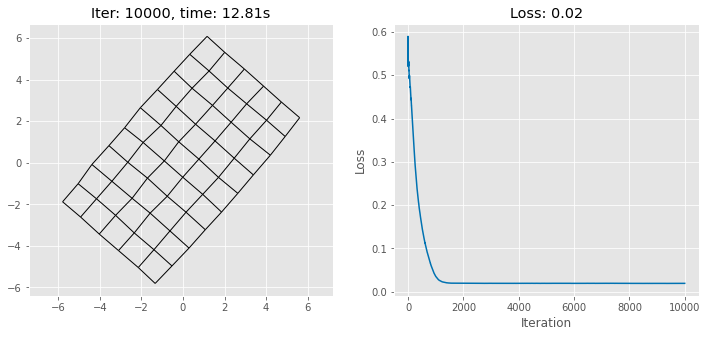

{'stress', 'edge_uniformity'}



{'stress': 0.02487236515974098, 'edge_uniformity': 0.034653306007385254, 'neighborhood_preservation': 0.07407408952713013, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.4242722988128662, 'angular_resolution': 0.27117133140563965, 'vertex_resolution': 0.4410094642716448, 'gabriel': 4.76837158203125e-07}


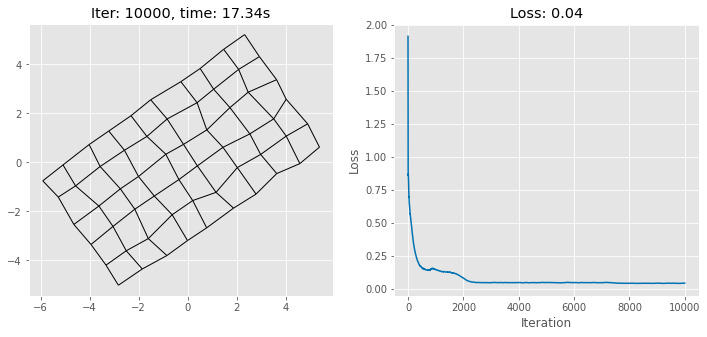

{'neighborhood_preservation', 'stress'}


In [ ]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2









criteria_weights = dict(
    stress=1,
    edge_uniformity=0.5,
    neighborhood_preservation=0.5,
    crossings=1,
    crossing_angle_maximization=0.1,
    aspect_ratio=10,
    angular_resolution=0.1,
    vertex_resolution=0.05,
    gabriel=0.5,
)

sample_sizes = dict(
    stress=64,
    edge_uniformity=int(len(G)**0.5),
    neighborhood_preservation=16,
    crossings=16,
    crossing_angle_maximization=10,
    aspect_ratio=int(len(G)**0.5),
    angular_resolution=32,
    vertex_resolution=int(len(G)**0.5),
#     vertex_resolution=len(G),
    gabriel=10,
)




## choose criteria
criteria_all = [
    'stress',
    'edge_uniformity',
    'neighborhood_preservation',
    'crossings',
    'crossing_angle_maximization',
    'aspect_ratio',
    'angular_resolution',
    'vertex_resolution',
    'gabriel',
]

criteria_pairs = [
    (ci, cj) for (i,ci), (j, cj) 
    in list(
        itertools.product(
            enumerate(criteria_all), 
            enumerate(criteria_all)
        ))
    if i<=j
]


for c1, c2 in tqdm(criteria_pairs):
    criteria_pair = {c1,c2}
    print(criteria_pair)

    gd = GD2(G)

    result = gd.optimize(
        criteria_weights={c:criteria_weights[c] for c in criteria_pair}, 
        sample_sizes=sample_sizes,
        evaluate=criteria_all,

        max_iter=10000, 
        evaluate_interval=10000//40,
        vis_interval=-10000//10,
#             clear_output=True,

        optimizer_kwargs = dict(lr=2),
        scheduler_kwargs = dict(verbose=False),
    )
    print(result['qualities'])

    pos = gd.pos.detach().numpy()
    pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
    vis.plot(
        gd.G, pos_G,
        gd.loss_curve, 
        result['iter'], result['runtime'],
        edge=True, show=True, save=False
    )



    ## store data
    if c1 == c2:
        fn = c1
    else:
        fn = f'{c1}-vs-{c2}'
    gd.save(f'{dir_out}/{fn}.pkl')




## plot examples in a matrix

In [11]:
import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2

In [25]:
def show_text(ax, text):
    plt.text(0, 0, f'{c1}', fontsize='x-large', ha='center')
    ax.set_facecolor('white')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xticks([])
    plt.yticks([])
            

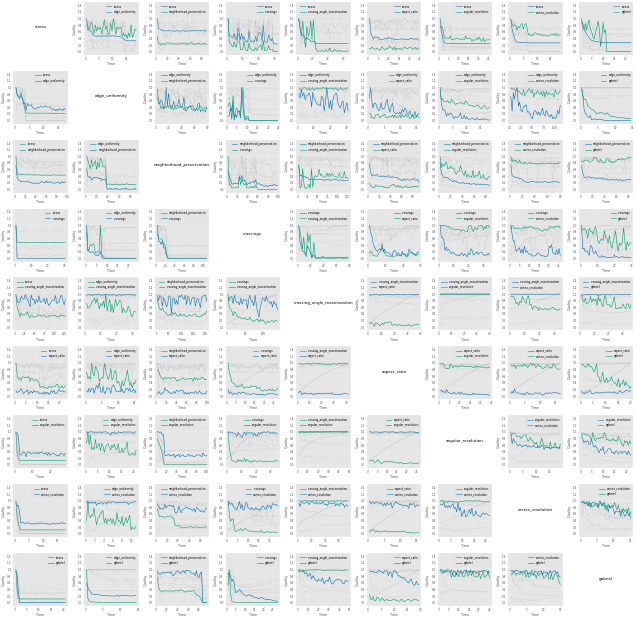

In [36]:
# dir_in = './analysis/criteria_pairs/tree_2_6-0'
# dir_in = './analysis/criteria_pairs/tree_2_5-t1633627830'

dir_in_upper = './analysis/criteria_pairs/tree_2_5-t1633999851'

# dir_in_lower = './analysis/criteria_pairs/grid_5_8-t1634182400'
dir_in_lower = './analysis/criteria_pairs/grid_6_10-t1634190792'


criteria_all = [
    'stress',
    'edge_uniformity',
    'neighborhood_preservation',
    'crossings',
    'crossing_angle_maximization',
    'aspect_ratio',
    'angular_resolution',
    'vertex_resolution',
    'gabriel',
]
n = len(criteria_all)
criteria_pairs = list(itertools.product(enumerate(criteria_all), enumerate(criteria_all)))


# mode = 'drawings'
# mode = 'criteria_pairs'
mode = 'learning_curves'


if mode == 'drawings':
    space = 0.05
    figsize = [35,35]
else:
    space = 0.3
    figsize = [40,40]
    
fig = plt.figure(figsize=figsize, dpi=20)
gs = GridSpec(n,n, wspace=space, hspace=space)

for (i,c1), (j,c2) in tqdm(criteria_pairs):
    
        if i == j:
#             fn = f'{dir_in_upper}/{c1}.pkl'
            ax = plt.subplot(gs[i,j])
            show_text(ax, f'{c1}')
            continue
        elif i<j:
            fn = f'{dir_in_upper}/{c1}-vs-{c2}.pkl'
        elif i>j:
            fn = f'{dir_in_lower}/{c2}-vs-{c1}.pkl'

            
        with open(fn, 'rb') as f:
            data = pkl.load(f)
            ax = plt.subplot(gs[i,j])
            
            if mode == 'drawings':
                ## draw graphs
                pos = data['pos'].detach().numpy()
                pos_G = {k:pos[data['k2i'][k]] for k in data['G'].nodes}
                vis.draw_graph(
                    data['G'], pos_G, ax=ax,
#                     ylabel=c1,# if j==0 else '',
#                     xlabel=c2,# if i==0 else '',
                )
                ax.xaxis.set_label_position('top')
                plt.axis('equal')
                ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                
            
            elif mode == 'criteria_pairs':
                ## plot learn curves
                t = [r['time'] for r in data['qualities_by_time']]
                quality_curve_x = [r['qualities'][c2] for r in data['qualities_by_time']]
                quality_curve_y = [r['qualities'][c1] for r in data['qualities_by_time']]
                plt.scatter(quality_curve_x, quality_curve_y, s=50, c=t)
                plt.xlabel(c2)
                plt.ylabel(c1)
                
                
            elif mode == 'learning_curves':
                ## plot quality curves       
                t = [r['time'] for r in data['qualities_by_time']]
                for c in criteria_all:
                    quality_curve = np.array([r['qualities'][c] for r in data['qualities_by_time']])
                    if c in {'stress', 'crossings', 'edge_uniformity'}:
                        quality_curve = quality_curve/quality_curve.max()
                        
                    if c == c1:
                        color, alpha, style = 'C0', 1.0, '-'
                    elif c == c2:
                        color, alpha, style = 'C1', 1.0, '-'
                    else:
                        color, alpha, style = '#aaa', 1.0, '-'
                    plt.plot(
                        t, quality_curve, 
                        style, 
                        label=c if c==c1 or c==c2 else None,
                        lw=2 if c==c1 or c==c2 else 0.5,
                        color=color,
                        alpha=alpha
                    )
                plt.xlabel('Time')
                plt.ylabel('Quality')
#                 plt.title(f'{c1} vs. {c2}')
                plt.legend()
                plt.ylim([-0.1, 1.5])

plt.savefig(f'{mode}-matrix.pdf', bbox_inches='tight', dpi=120)
plt.show()
            


## testing reyans hyper cubes

In [ ]:
import json
log_dir = 'reyan/log_folder/'
problematic_files = ['input_11.txt', 'input_18.txt', 'input_26.txt', 'input_27.txt', 'input_28.txt', 'input_48.txt', 'input_56.txt', 'input_63.txt', 'input_70.txt', 'input_71.txt', 'input_73.txt', 'input_74.txt', 'input_75.txt', 'input_76.txt', 'input_93.txt', 'input_94.txt', 'input_95.txt', 'input_101.txt', 'input_102.txt', 'input_103.txt', 'input_108.txt', 'input_109.txt', 'input_110.txt', 'input_115.txt', 'input_116.txt', 'input_117.txt', 'input_118.txt', 'input_120.txt', 'input_121.txt', 'input_122.txt', 'input_123.txt', 'input_124.txt', 'input_125.txt', 'input_126.txt', 'input_127.txt', 'input_128.txt', 'input_129.txt', 'input_134.txt', 'input_137.txt', 'input_138.txt', 'input_139.txt', 'input_140.txt', 'input_146.txt', 'input_147.txt', 'input_148.txt', 'input_153.txt', 'input_154.txt', 'input_155.txt', 'input_157.txt', 'input_160.txt', 'input_161.txt', 'input_162.txt', 'input_163.txt', 'input_164.txt', 'input_166.txt', 'input_167.txt', 'input_168.txt', 'input_169.txt', 'input_170.txt', 'input_171.txt', 'input_172.txt', 'input_173.txt', 'input_174.txt', 'input_179.txt', 'input_183.txt', 'input_184.txt', 'input_185.txt', 'input_191.txt', 'input_192.txt', 'input_193.txt', 'input_198.txt', 'input_199.txt', 'input_200.txt', 'input_202.txt', 'input_205.txt', 'input_206.txt', 'input_208.txt', 'input_209.txt', 'input_211.txt', 'input_212.txt', 'input_213.txt', 'input_214.txt', 'input_215.txt', 'input_216.txt', 'input_217.txt', 'input_218.txt', 'input_219.txt', 'input_224.txt']
pairs = []
for fn in problematic_files:
    with open(log_dir+fn) as f:
        params = json.load(f)
        graph_str = f'{params["graph"]} {params["graph_param_1"]}'
        pairs.append(
            (tuple(sorted(params['metrics'])),)
            +(graph_str,fn.split('/')[-1].split('.')[0])
        )
        
# for criteria, graph, fn in natsorted(pairs, key=lambda x:x[-1]):
for criteria, graph, fn in natsorted(pairs, key=lambda x:x):
    print(f'{graph}\t{fn:<12} {criteria} ')

In [ ]:
from pathlib import Path

In [ ]:
log_dir = 'log_folder/'
problematic_files = ['input_11.txt', 'input_18.txt', 'input_26.txt', 'input_27.txt', 'input_28.txt', 'input_48.txt', 'input_56.txt', 'input_63.txt', 'input_70.txt', 'input_71.txt', 'input_73.txt', 'input_74.txt', 'input_75.txt', 'input_76.txt', 'input_93.txt', 'input_94.txt', 'input_95.txt', 'input_101.txt', 'input_102.txt', 'input_103.txt', 'input_108.txt', 'input_109.txt', 'input_110.txt', 'input_115.txt', 'input_116.txt', 'input_117.txt', 'input_118.txt', 'input_120.txt', 'input_121.txt', 'input_122.txt', 'input_123.txt', 'input_124.txt', 'input_125.txt', 'input_126.txt', 'input_127.txt', 'input_128.txt', 'input_129.txt', 'input_134.txt', 'input_137.txt', 'input_138.txt', 'input_139.txt', 'input_140.txt', 'input_146.txt', 'input_147.txt', 'input_148.txt', 'input_153.txt', 'input_154.txt', 'input_155.txt', 'input_157.txt', 'input_160.txt', 'input_161.txt', 'input_162.txt', 'input_163.txt', 'input_164.txt', 'input_166.txt', 'input_167.txt', 'input_168.txt', 'input_169.txt', 'input_170.txt', 'input_171.txt', 'input_172.txt', 'input_173.txt', 'input_174.txt', 'input_179.txt', 'input_183.txt', 'input_184.txt', 'input_185.txt', 'input_191.txt', 'input_192.txt', 'input_193.txt', 'input_198.txt', 'input_199.txt', 'input_200.txt', 'input_202.txt', 'input_205.txt', 'input_206.txt', 'input_208.txt', 'input_209.txt', 'input_211.txt', 'input_212.txt', 'input_213.txt', 'input_214.txt', 'input_215.txt', 'input_216.txt', 'input_217.txt', 'input_218.txt', 'input_219.txt', 'input_224.txt']

for fn in problematic_files:
        
    with open(log_dir+fn) as json_file:
        input_param = json.load(json_file)
    
    graph_str = (
        input_param['graph']
        + ' ' 
        + ' '.join(input_param[k] for k in natsorted(input_param) if k.startswith('graph_param_'))
    )
    metrics = input_param['metrics']
    print(f'='*40)
    print(f'fn: {fn}')
    print(f'metrics: {metrics}')
    print(f'graph: {graph_str}')
    
    if Path(input_param["output_file"]).exists():
        continue
          
    print('generating graph', end=' ')
    if input_param["graph"]=="tree":
        G = nx.balanced_tree(int(input_param["graph_param_1"]), int(input_param["graph_param_2"]))
    elif input_param["graph"]=="hypercube":
        G = nx.hypercube_graph(int(input_param["graph_param_1"]))
    elif input_param["graph"]=="grid":
        dim = int(input_param["graph_param_1"])
        G = nx.grid_graph(dim = [dim, dim])
    print(f'of {len(G)} nodes')
    
    max_iter = 10000
    criteria_weights_default = {
        'stress': 4,
        'edge_uniformity':1,
        'neighborhood_preservation':0.5,
        'crossings':1,
        'crossing_angle_maximization':0.1,
        'aspect_ratio':10,
        'angular_resolution':0.1,
        'vertex_resolution':1,
        'gabriel':0.01,
    }

    sample_sizes_default = {
        'stress': 64,
        'edge_uniformity': 10,
        'neighborhood_preservation': 16,
        'crossings': 10,
        'crossing_angle_maximization':10,
        'aspect_ratio': 'full',
        'angular_resolution': 10,
        'vertex_resolution': int(len(G)**0.5),
        'gabriel': 10,
    }


    criteria_weights = {}
    for m in input_param['metrics']:
        criteria_weights[m] = criteria_weights_default[m]


    gd = GD2(G)
    result = gd.optimize(
        criteria_weights=criteria_weights,
        sample_sizes=sample_sizes_default,

        evaluate='all',
    #     evaluate={'neighborhood_preservation'},
#         evaluate=set(input_param['metrics']),

        max_iter=max_iter, 
        evaluate_interval=-1,
        vis_interval=-1,

        optimizer_kwargs = dict(lr=1),
        scheduler_kwargs = dict(verbose=False),
    )


    for q,v in result['qualities'].items():
        print(q,v)

    return_dict = dict(
        metric_value=result['qualities'],
        pos=result['pos'].detach().cpu().tolist(),
        time=result['runtime']
    )
    
    with open(input_param["output_file"], 'w') as fp:
        json.dump(return_dict, fp)
          
          
    ## vis for debugging
    pos = gd.pos.detach().numpy()
    pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
    vis.plot(
        gd.G, pos_G,
        gd.loss_curve, 
        result['iter'], result['runtime'],
        edge=True, show=True, save=False
    )

    

In [ ]:

# from utils import lovasz_losses as L
# a = torch.eye(5)
# pred = torch.randn(5,5)
# L.lovasz_softmax(pred, a)

## Analysis of sample size

In [ ]:
# import importlib
# importlib.reload(C)
# importlib.reload(Q)
# importlib.reload(utils)
# importlib.reload(vis)
# importlib.reload(gd2)

In [ ]:
import pandas as pd
import itertools

In [ ]:
df

In [ ]:
# cm = plt.cm.viridis()

# for result in results:
    
#     sample_size = result['sample_sizes']['stress']
    
#     t = [x['time'] for x in result['qualities_by_time']]
#     stress = [x['qualities']['stress'] for x in result['qualities_by_time']]
    
#     plt.plot(t, stress, '.-', label=f'sample_size = {sample_size}', color=cm(np.log2(sample_size)/np.log2(512)))
    
# plt.xlabel('Total Time (sec)')
# plt.ylabel('Stress')
# plt.yscale('log')

# plt.xlim([-10,100])
# plt.legend()
# plt.savefig('time-vs-stress-curve-by-sample-size-100sec.png')
# plt.show()

In [ ]:
# df.to_csv('./analysis/balanced-tree-2-8.csv')

In [ ]:
df.plot('sample_size', 'runtime', style='o')
df.plot('sample_size', 'stress', style='o');

In [ ]:
plt.scatter(
    df['runtime'], 
    df['stress'], 
    s=df['sample_size']+10, 
    linewidth=1,
    edgecolor='#eee',
    alpha=0.8,
#     c=df['sample_size']+10,
    label='Sample Size',
)

# plt.xscale('symlog')
plt.xlabel('Runtime')
plt.xlim([0, plt.xlim()[1]*1.1])

# plt.yscale('log')
plt.ylabel('Stress')
plt.ylim([0, plt.ylim()[1]*1.1])

plt.savefig('figures-tmp/runtime-vs-stress-by-sample_rate.png')

## Dev

In [ ]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)


runtime = []

niter = int(1e6)

shouldVis = True
visIter = 5000

shouldSnap = True
snapIter = 5

gClamp = 4
minLR = 1e-5
maxSampleSize = 64


totalTime = 0

print('generating graph', end=' ')
# G = nx.grid_2d_graph(18,36)
# G = nx.hypercube_graph(3)
# G = nx.balanced_tree(2,4)
G = utils.load_spx_teaser()
# G = nx.karate_club_graph()


# graph_name = 'grid1'
# graph_name = 'grid1_dual'
# graph_name = 'odepa400'
# graph_name = 'netz4504_dual'
# graph_name = 'L'
# -----
# graph_name = 'netz4504'
# graph_name = 'qh882'
# mat_dir = 'graphs/SuiteSparse Matrix Collection'
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')


# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])




print(f'of {len(G)} nodes')
maxDegree = max(dict(G.degree).values())
print('Calculating all pairs shortest path', end='...')
t0 = time.time()

# D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
# adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
D, adj_sparse, k2i = utils.shortest_path(G)
adj = torch.from_numpy(adj_sparse.toarray())
D = torch.from_numpy(D)

i2k = {i:k for k,i in k2i.items()}
edge_indices = [(k2i[e0], k2i[e1]) for e0,e1 in G.edges]
node_indices = range(len(G))
node_index_pairs = np.c_[
    np.repeat(node_indices, len(G)),
    np.tile(node_indices, len(G))
]
node_index_pairs_start = 0
np.random.shuffle(node_index_pairs)


    
dt = time.time() - t0
totalTime += dt

W = 1/(D**2+1e-6)
truth = adj + torch.eye(adj.shape[0], device=device)
print('done')


##training
#     pos = torch.rand(len(G.nodes), 2, device=device)*2-1
pos = torch.randn(len(G.nodes), 2, device=device)
pos.requires_grad_(True)


##LOAD prev layout
# G_ = nx.read_gpickle(glob(f'layouts/balanced_tree_{2}_{7}-stress-*.gpickle')[0])
# pos = {k2i[k]: G_.nodes[k]['pos'] for k in G_.nodes}
# pos = torch.stack([torch.from_numpy(pos[i]) for i in range(len(pos))])
# pos = pos.requires_grad_(True)


optimizer = optim.SGD([pos], lr=0.1, momentum=0.7, nesterov=True)
# optimizer = optim.RMSprop([pos], lr=0.01)
# optimizer = optim.Adam([pos], lr=0.001)


# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=np.ceil(np.log2(len(G)+1))*100, 
    min_lr=minLR, verbose=True
)
# scheduler = optim.lr_scheduler.LambdaLR(
#     optimizer, 
#     lr_lambda=lambda e:1*(1-e/niter)
# )


iterBar = tqdm(range(niter))
lossCurve = []
sampleSize = min(len(G), maxSampleSize)
degrees = adj.sum(1).numpy().astype(np.int64)
xPath = []

qualityMeasureInterval = max(1, niter // 30)
qualityMeasureCurves = defaultdict(list)
activeQualityMeasures = [
    'stress',
#     'edge_uniformity',
#     'neighborhood_preservation',
#     'crossings',
    
#     'crossing_angle_maximization',
    'aspect_ratio',
#     'angular_resolution',
#     'vertex_resolution',
#     'gabriel',
    
]

for i in iterBar:
    t0 = time.time()
    
    ## optimization
    optimizer.zero_grad()

    if node_index_pairs_start >= len(node_index_pairs):
        np.random.shuffle(node_index_pairs)
        node_index_pairs_start = 0
    stress_samples = node_index_pairs[node_index_pairs_start:node_index_pairs_start+sampleSize]
    
    loss = (
        +C.stress(pos, D, W, samples=stress_samples)
#         +0.5*C.edge_uniformity(pos, G, k2i, sampleSize-1)
#         +0.1*C.angular_resolution(pos, G, k2i, sampleSize=sampleSize//maxDegree)
#         + 10*C.aspect_ratio(pos, sampleSize)
#         C.crossing_angle_maximization(pos, G, k2i, i2k, sampleSize=10, sampleOn='crossings') ## slow for large sample size
#     +0.001*C.vertex_resolution(pos, sampleSize, target=1/len(G)**0.5)
#     + 0.1*C.gabriel(pos, G, k2i, sampleSize=int(sampleSize**0.5))
#         +1*C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=4, sampleOn='crossings')
#         +C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=20, sampleOn='edges')
#         C.neighborhood_preseration(pos, G, adj, k2i, i2k, n_roots=2, depth_limit=2)
    )
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()
    
    node_index_pairs_start+=sampleSize
    
    ## debug info
    totalTime += time.time() - t0
    if loss.isnan():
        raise Exception('loss is nan')
    if pos.isnan().any():
        raise Exception('pos is nan')
    
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({'loss': loss.item(), })    
    if len(lossCurve) > 0:
        lossCurve.append(0.9*lossCurve[-1] + 0.1*loss.item())
    else:
        lossCurve.append(loss.item())
    if shouldSnap and i % snapIter == 0:
        x = pos.detach().cpu().numpy()
        xPath.append(x.copy())    
    
    
    ## quality measures
    if i % qualityMeasureInterval == qualityMeasureInterval-1:
        if 'stress' in activeQualityMeasures:
            qualityMeasureCurves['stress'].append(
                Q.stress(pos, D, W, None)
            )
        if 'edge_uniformity' in activeQualityMeasures:
            qualityMeasureCurves['edge_uniformity'].append(
                Q.edge_uniformity(pos, G, k2i)
            )
        if 'neighborhood_preservation' in activeQualityMeasures:
            qualityMeasureCurves['neighborhood_preservation'].append(
                Q.neighborhood_preservation(pos, G, adj, i2k)
            )
        if 'crossings' in activeQualityMeasures:
            qualityMeasureCurves['crossings'].append(
                Q.crossings(pos, edge_indices)
            )
        if 'crossing_angle_maximization' in activeQualityMeasures:
            qualityMeasureCurves['crossing_angle_maximization'].append(
                Q.crossing_angle_maximization(pos, G.edges, k2i)
            )
        if 'aspect_ratio' in activeQualityMeasures:
            qualityMeasureCurves['aspect_ratio'].append(
                Q.aspect_ratio(pos)
            )
        if 'angular_resolution' in activeQualityMeasures:
            qualityMeasureCurves['angular_resolution'].append(
                Q.angular_resolution(pos, G, k2i)
            )
            
        if 'vertex_resolution' in activeQualityMeasures:
            qualityMeasureCurves['vertex_resolution'].append(
                Q.vertex_resolution(pos, target=1/len(G)**0.5)
            )
        if 'gabriel' in activeQualityMeasures:
            qualityMeasureCurves['gabriel'].append(
                Q.gabriel(pos, G, k2i)
            )
        

    ##vis
    if shouldVis and i % visIter == visIter-1:
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossCurve, [], i, totalTime, node_size=6, edge=True, show=True, save=False)
    
        
    
    if scheduler is not None:
#         scheduler.step(i)
        scheduler.step(lossCurve[-1])
    

    if optimizer.param_groups[0]['lr'] <= minLR:
#     or pos.grad.max() < 1e-3*(pos.max()-pos.min()):
        print('Done')
        break

In [ ]:
# show final result
x = pos.detach().cpu().numpy()
pos_i = {k: x[k2i[k], :2] for k in G.nodes}
vis.plot(G, pos_i, lossCurve, [], i, totalTime,  
         show=True, save=False, title=f'|V|={len(G)}, iter: {i}, time: {totalTime:.2f} sec')
totalTime

In [ ]:
for q in activeQualityMeasures:
    plt.figure(figsize=[6,3])
    plt.plot(qualityMeasureCurves[q],'.-')
    plt.ylabel(' '.join(s.capitalize() for s in q.split('_')))
    plt.title(' '.join(s.capitalize() for s in q.split('_')))
    plt.show()
    print(qualityMeasureCurves[q])

In [ ]:
1/len(G)**0.5

In [ ]:
# fig, ax = plt.subplots()

# nx.draw_networkx(G, pos_i, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## Animation

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# if type(xPath) == list:
#     xPath = np.stack(xPath)
    
# padding = 0.1

# fig, ax = plt.subplots()
# scatter = plt.scatter([0], [0], s=10)
# lc = mc.LineCollection([], linewidths=1)
# ax.add_collection(lc)

# xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
# ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
# xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
# ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
    
# def init():
#     return scatter,lc

# def update(frame):
#     xy = xPath[frame]
#     scatter.set_offsets(xy)
#     segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
#     lc.set_segments(segs)
#     return scatter,lc

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=range(0,len(xPath),1),
#     init_func=init, 
#     interval=1000.0/20,
#     blit=True)

# HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)